# Start neo4j docker container

In [67]:
import subprocess

subprocess.run(['docker', 'run',
                '--rm', '-d',
                '-e', 'NEO4J_AUTH=none',
                '-p', '7687:7687',
                '-p', '7474:7474',
                '--name', 'bench',
                'neo4j:3.5'])

CompletedProcess(args=['docker', 'run', '--rm', '-d', '-e', 'NEO4J_AUTH=none', '-p', '7687:7687', '-p', '7474:7474', '--name', 'bench', 'neo4j:3.5'], returncode=0)

Transaction failed and will be retried in 18.57252486497345s (Connection pool closed)
Transaction failed and will be retried in 13.183661447818317s (Connection pool closed)
Transaction failed and will be retried in 17.24361799439328s (Connection pool closed)
Transaction failed and will be retried in 18.52174208185227s (Connection pool closed)
Transaction failed and will be retried in 16.85926757495961s (Connection pool closed)
Transaction failed and will be retried in 14.118181887715668s (Connection pool closed)
Transaction failed and will be retried in 14.693485036872755s (Connection pool closed)
Transaction failed and will be retried in 16.722775024206545s (Connection pool closed)
Transaction failed and will be retried in 16.753421805188932s (Connection pool closed)
Transaction failed and will be retried in 16.150301939845857s (Connection pool closed)
Transaction failed and will be retried in 14.11014677666206s (Connection pool closed)
Transaction failed and will be retried in 36.127

# Connect to neo4j (wait a bit before executing)

In [68]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver("bolt://localhost:7687", max_connection_pool_size=50)

# Example query

In [55]:
def query(tx, n):
    nodes = ['()'] * n
    nodes = ','.join(nodes)
    query = f'create {nodes}'
    return tx.run(query)

with driver.session() as session:
    session.write_transaction(query, 1)

# How we'll get disk usage

In [56]:
def du():
    return subprocess.run(['docker', 'exec', 'bench',
                       'du', '-bc', '/data'],
                      capture_output=True, encoding='utf-8')

proc = du()
print(proc.stdout)

4096	/data/databases/graph.db/index
123244	/data/databases/graph.db
127340	/data/databases
131436	/data
131436	total



# How we'll parse it

In [57]:
def parse(proc):
    return float(proc.stdout.split('\n')[-2].split('\t')[0])

parse(proc)

131436.0

# Create 10^4, 10^5, ..., 10^9 nodes and collect their disk usage

In [69]:
from concurrent.futures import ThreadPoolExecutor
from time import time

def do_work(n):
    with driver.session() as session:
        session.write_transaction(query, n)

x = range(4, 10)
y = []

for p in x:
    n = 10 ** p
    if p > 4:
        n -= 10 ** (p-1)  # Minus the nodes created in the previous iteration
    
    start = time()
    # Using executor in a with statement will wait for all futures to finish before exiting
    # https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.shutdown
    with ThreadPoolExecutor() as executor:
        one_chunk = 10 ** 4
        chunks, remain = divmod(n, one_chunk)
        for _ in range(chunks):
            executor.submit(do_work, one_chunk)
        if remain > 0:
            do_work(remain)
        
    proc = du()
    y.append(parse(proc))
    
    print('Done with p =', p, 'in', time() - start)

Done with p = 4 in 1.5182149410247803
Done with p = 5 in 1.614102840423584
Done with p = 6 in 3.504718065261841
Done with p = 7 in 35.03845715522766
Done with p = 8 in 184.07972741127014
Done with p = 9 in 1436.703712940216
range(4, 10)
[3104878277.0, 3207538260.0, 3410018271.0, 4567563872.0, 15034935088.0, 74222322303.0]


# Plot disk usage vs number of nodes

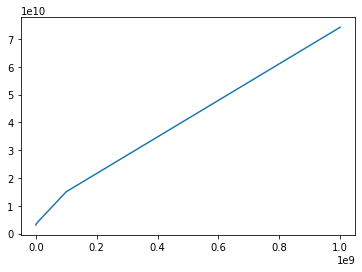

In [10]:
from matplotlib import pyplot as plt

plt.plot([10 ** p for p in x], y)

So it seems storage increase linearly with number of nodes

# Disconnect and remove neo4j

In [11]:
driver.close()
subprocess.run(['docker', 'stop', 'bench'])

NameError: name 'driver' is not defined